In [1]:
# Some standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Libraries for creating, running and visualizing quantum circuits 
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, clear_output

# Libraries for using Quantum Inspire
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI
from os import getenv
QI_URL = getenv('API_URL', 'https://api.quantum-inspire.com/')

#%run CircuitTesting.ipynb

## Circuit

In [2]:
# Gates
def circuit(theta, qcx, qcy, qcz, qx, qy, qz, cx, cy, cz):
    # X-axis
    qcx.initialize([1, 0],0)
    qcx.initialize([0, 1],1)
    qcx.rx(-3*np.pi/2,qx[0])  #-X(pi/2) gate
    qcx.ry(np.pi/2,qx[1])    # Y(pi/2) gate
    qcx.cnot(qx[1],qx[0])     # CNOT 1->0
    qcx.rz(theta,qx[0])      # Z(theta) gate with theta suggested by classical optimizer
    qcx.cnot(qx[1],qx[0])     # CNOT 1->0
    qcx.ry(-3*np.pi/2,qx[1]) #-Y(pi/2) gate
    qcx.rx(np.pi/2,qx[0])    # X(pi/2) gate
    qcx.ry(np.pi/2,qx[0])
    qcx.ry(-np.pi/2,qx[1])
    qcx.barrier(qx)
    qcx.measure(qx,cx)
    # Y-axis
    qcy.initialize([1, 0],0)
    qcy.initialize([0, 1],1)
    qcy.rx(-3*np.pi/2,qy[0])  #-X(pi/2) gate
    qcy.ry(np.pi/2,qy[1])    # Y(pi/2) gate
    qcy.cnot(qy[1],qy[0])     # CNOT 1->0
    qcy.rz(theta,qy[0])      # Z(theta) gate with theta suggested by classical optimizer
    qcy.cnot(qy[1],qy[0])     # CNOT 1->0
    qcy.ry(-3*np.pi/2,qy[1]) #-Y(pi/2) gate
    qcy.rx(np.pi/2,qy[0])    # X(pi/2) gate
    qcy.rx(np.pi/2,qy[0])
    qcy.rx(-np.pi/2,qy[1])
    qcy.barrier(qy)
    qcy.measure(qy,cy)
    # Z-axis
    qcz.initialize([1, 0],1)
    qcz.initialize([0, 1],0)
    qcz.rx(-3*np.pi/2,qz[0])  #-X(pi/2) gate
    qcz.ry(np.pi/2,qz[1])    # Y(pi/2) gate
    qcz.cnot(qz[1],qz[0])     # CNOT 1->0
    qcz.rz(theta,qz[0])      # Z(theta) gate with theta suggested by classical optimizer
    qcz.cnot(qz[1],qz[0])     # CNOT 1->0
    qcz.ry(-3*np.pi/2,qz[1]) #-Y(pi/2) gate
    qcz.rx(np.pi/2,qz[0])    # X(pi/2) gate
    qcz.barrier(qz)
    qcz.measure(qz,cz)
    
# Apply gates to circuit
#circuit(qcx, qcy, qcz, qx, qy, qz)
#display(qcx.draw(output='mpl')) # draw circuit using output method matplotlib
#display(qcy.draw(output='mpl')) # draw circuit using output method matplotlib
#display(qcz.draw(output='mpl')) # draw circuit using output method matplotlib

In [3]:
def create_probabilities(state_distribution):
    return state_distribution / np.sum(state_distribution)

def run_simulation(qcx, qcy, qcz ,qx, qy, qz, cx, cy, cz, r):
    theta = Parameter('θ') # create a variable for the z-rotation gate
    circuit(theta, qcx, qcy, qcz ,qx, qy, qz, cx, cy, cz)
    theta_range = np.linspace(0,2*np.pi,r)
    circuitsX = [qcx.bind_parameters({theta: theta_val}) for theta_val in theta_range]
    circuitsY = [qcy.bind_parameters({theta: theta_val}) for theta_val in theta_range]
    circuitsZ = [qcz.bind_parameters({theta: theta_val}) for theta_val in theta_range]

    backend = BasicAer.get_backend('qasm_simulator')
    job = backend.run(transpile(circuitsX, backend))
    countsX = job.result().get_counts()
    probabilitiesX = []
    for res in job.result().results:
        local_count = res.data.counts
        distribution = np.zeros(4)
        for key in local_count:
            distribution[int(key, 16)] += local_count[key]
        probabilitiesX.append(create_probabilities(distribution))
    
    job = backend.run(transpile(circuitsY, backend))
    countsY = job.result().get_counts()
    probabilitiesY = []
    for res in job.result().results:
        local_count = res.data.counts
        distribution = np.zeros(4)
        for key in local_count:
            distribution[int(key, 16)] += local_count[key]
        probabilitiesY.append(create_probabilities(distribution))
    
    job = backend.run(transpile(circuitsZ, backend))
    countsZ = job.result().get_counts()
    probabilitiesZ = []
    for res in job.result().results:
        local_count = res.data.counts
        distribution = np.zeros(4)
        for key in local_count:
            distribution[int(key, 16)] += local_count[key]
        probabilitiesZ.append(create_probabilities(distribution))
    return [countsX, countsY, countsZ], [probabilitiesX, probabilitiesY, probabilitiesZ]

# ZI = |a|^2 + |b|^2 - |c|^2 - |d|^2
def zi(prob):
    return prob[0] + prob[1] - prob[2] - prob[3]

# IZ = |a|^2 - |b|^2 + |c|^2 - |d|^2
def iz(prob):
    return prob[0] - prob[1] + prob[2] - prob[3]

def compute_prob(prob):
    return prob[0] - prob[1] - prob[2] + prob[3]

def get_counts_and_probabilities(shots=40):
    # Initialsiation of circuit
    n = 2                        # number of qubits
    N = 2**n                     # number of possible (classical) states
    qx = QuantumRegister(n,'q')   # quantum register of n qubits
    qy = QuantumRegister(n,'q')   # quantum register of n qubits
    qz = QuantumRegister(n,'q')   # quantum register of n qubits
    cx = ClassicalRegister(n,'c') # classical register of 1 bit
    cy = ClassicalRegister(n,'c') # classical register of 1 bit
    cz = ClassicalRegister(n,'c') # classical register of 1 bit
    qcx = QuantumCircuit(qx,cx)     # quantum circuit on register
    qcy = QuantumCircuit(qy,cy)     # quantum circuit on register
    qcz = QuantumCircuit(qz,cz)     # quantum circuit on register
    counts, probabilities = run_simulation(qcx, qcy, qcz ,qx, qy, qz, cx, cy, cz, shots)
    return counts, probabilities

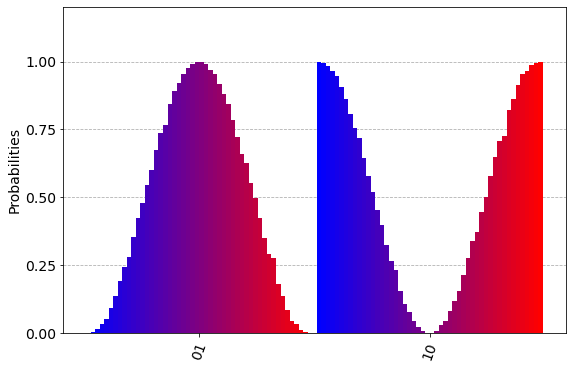

In [4]:
shots = 50
counts, probabilities = get_counts_and_probabilities(shots)
R = np.linspace(0,1,shots)
G = np.zeros(shots)
B = np.linspace(1,0,shots)
cmap = [(r,g,b) for r,g,b in zip(R,G,B)]

fig = plot_histogram(counts[2],figsize=(9,6),color=cmap,bar_labels=False)
fig.patch.set_facecolor('white')
display(fig)

## Hamiltonian using Qiskit (PyQuante2 driver)

##### Import modules

- `Molecule`: used to create a molecule instance storing all relevant data
- `ElectronicStructureDriverType`: used to specify the driver used in calculations
- `ElectronicStructureMoleculeDriver`: Molecule based electronic structure driver
- `ElectronicStructureProblem`: generates electronic structure problem which we want to solve
- `QubitConverter`: converts hamiltonian from second-quantized to qubit (spin) operators
- `...Mapper`: used by `QubitConverter` to map fermionic operators to qubit operators

- `settings.dict_aux_operators=True` sets `ElectronicStructureProblem` output to dict instead of list

In [5]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature import settings
settings.dict_aux_operators = True

##### Create molecule and driver

The geometry of the hydrogen molecule is given as a linear array of 2 hydrogen atoms with a spacing on the z-axis of $0.7414$ Å ($=7.414\cdot10^{-12}$ m). Hydrogen molecules are electrically neutral, so charge $Q=0$ C. Spin multiplicity is defined as $2S+1$, here we assume the singlet state with $S=0$*.

In [6]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.7414]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE
)

###### The spin of a Hydrogen molecule consists of the nuclear spins of both protons ($s=1/2$). The electron spins cancle because they need to be opposite to create a covalent bond between the two atoms. The nuclear spins can be either aligned, forming a triplet state called orthohydrogen with $S=1$, or anti-aligned, forming a singlet state called parahydrogen with $S=0$. At room temperature hydrogen consists for about 25% of parahydrogen. parahydrogen is in a lower energy state than orthohydrogen and since we are searching for the ground state, we use this $S=0$ state.

##### Create electronic structure problem and return second-quantized operators

In [7]:
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op['ElectronicEnergy'])

Fermionic Operator
register length=4, number terms=14
  (0.18128881027902397+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.181288810279024+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.181288810279024+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18128881027902402+0j) * ( -_0 +_1 -_2 +_3 )
+  ...


##### Convert second-quantized to spin/qubit operators using Jordan Wigner transformation

In [8]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
print(qubit_op)

-0.8126179806443667 * IIII
- 0.22278593632540367 * ZIII
+ 0.17119775959783223 * IZII
+ 0.120544822713764 * ZZII
- 0.22278593632540364 * IIZI
+ 0.17434844455135626 * ZIZI
+ 0.16586702528352001 * IZZI
+ 0.17119775959783207 * IIIZ
+ 0.16586702528352001 * ZIIZ
+ 0.1686221935535854 * IZIZ
+ 0.120544822713764 * IIZZ
+ 0.045322202569756 * XXXX
+ 0.045322202569756 * YYXX
+ 0.045322202569756 * XXYY
+ 0.045322202569756 * YYYY


C:\Users\Matej\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Convert second-quantized to spin/qubit operators using Bravyi-Kitaev transformation

In [9]:
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
print(qubit_op)

-0.8126179806443667 * IIII
+ 0.17119775959783223 * IZII
+ 0.120544822713764 * IIZI
+ 0.120544822713764 * ZIZI
- 0.22278593632540367 * ZZZI
+ 0.17119775959783207 * IIIZ
+ 0.1686221935535854 * IZIZ
+ 0.17434844455135626 * ZZIZ
- 0.22278593632540364 * IIZZ
+ 0.16586702528352001 * IZZZ
+ 0.16586702528352001 * ZZZZ
+ 0.045322202569756 * IXIX
+ 0.045322202569756 * ZXIX
- 0.045322202569756 * IXZX
- 0.045322202569756 * ZXZX


##### Convert second-quantized to spin/qubit operators using Parity mapper, which uses known symmetries to reduce the problem to 2 qubits

In [10]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
print(qubit_op)

(-1.0537076260718943+8.326672684688674e-17j) * II
+ (-0.39398369592323584+1.3877787807814457e-17j) * ZI
+ (0.3939836959232356+1.3877787807814457e-17j) * IZ
+ (-0.011236587537901618-1.3877787807814457e-17j) * ZZ
+ 0.18128881027902394 * XX


In [19]:
def get_coefficients(molecule):
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE
    )
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
    return qubit_op.coeffs

C:\Users\Matej\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Expectation values $\langle H(\theta) \rangle$

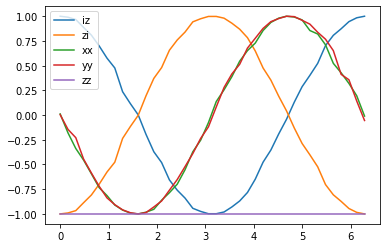

In [20]:
counts, probabilities = get_counts_and_probabilities(40)
results = {'iz': [], 'zi': [], 'xx': [], 'yy': [], 'zz': []}
theta_range = np.linspace(0,2*np.pi,40)
for index, theta in enumerate(theta_range):
    exp_zi = zi(probabilities[2][index])
    exp_iz = iz(probabilities[2][index])
    exp_xx = compute_prob(probabilities[0][index])
    exp_yy = compute_prob(probabilities[1][index])
    exp_zz = compute_prob(probabilities[2][index])
    results['iz'].append(exp_iz)
    results['zi'].append(exp_zi)
    results['xx'].append(exp_xx)
    results['yy'].append(exp_yy)
    results['zz'].append(exp_zz)
    #data.append(sum(qubit_op.coeffs * np.array([1, exp_zi, exp_iz, exp_zz, exp_xx])))

plt.plot(theta_range, results['iz'], label='iz')
plt.plot(theta_range, results['zi'], label='zi')
plt.plot(theta_range, results['xx'], label='xx')
plt.plot(theta_range, results['yy'], label='yy')
plt.plot(theta_range, results['zz'], label='zz')
plt.legend()
plt.show()

## Ground state solver using VQE

C:\Users\Matej\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Matej\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


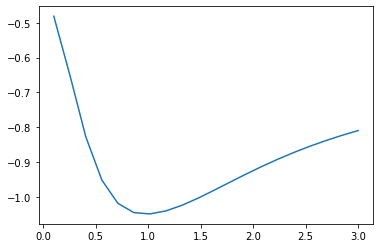

In [22]:
def compute_energy(distance, counts, probabilities):
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, distance]]], charge=0, multiplicity=1
    )
    coefficients = get_coefficients(molecule)
    
    data = []
    for index, theta in enumerate(probabilities[2]):
        exp_zi = zi(probabilities[2][index])
        exp_iz = iz(probabilities[2][index])
        exp_xx = compute_prob(probabilities[0][index])
        exp_yy = compute_prob(probabilities[1][index])
        exp_zz = compute_prob(probabilities[2][index])
        data.append(sum(coefficients * np.array([1, exp_zi, exp_iz, exp_zz, exp_xx])))
    return np.mean(data)

def vqa():
    shots = 50
    acc = 20
    min_dist = 0.1 
    max_dist = 3
    distance_range = np.linspace(min_dist, max_dist, acc)
    counts, probabilities = get_counts_and_probabilities(shots)
    
    return [compute_energy(d, counts, probabilities) for d in distance_range], distance_range


results, distance_range = vqa()
plt.plot(distance_range, results)
plt.show()